<a href="https://colab.research.google.com/github/bieri2/ATMS597-Project6-GroupB/blob/master/ATMS597_Project6_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from itertools import product
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

Some code in this notebook is adapted from the following sources: \\
https://www.tensorflow.org/tutorials/keras/regression \\
https://www.tensorflow.org/tutorials/keras/overfit_and_underfit \\
https://www.tensorflow.org/tutorials/keras/classification

In [0]:
def prep_data(df, features, mtype, target):
    """
    Prepares data for input to neural network. 

    Parameters:
    -df (DataFrame): DataFrame containing features and targets.
    -features (list): List of features to be used for training.
    -mtype (string, 'reg' or 'class'): Specifies whether data should be prepped for regression or classification.
    -target (string): The target variable name (must be in df).

    Returns:
    -Training and testing arrays (X and Y).
    """

    # Drop NaNs 
    df = df.dropna()

    # Do this if classification
    if mtype == 'class':
        # For classification, the target variable will be transformed to a binarized array
        # The binarized array will be based on standardized anomalies of the target data 

        # Calculate standardized anomalies of target data
        std_anoms = df[target].groupby(df.index.dayofyear).transform(lambda x: (x - x.mean())/x.std())
        # Create empty array to hold binarized data
        binary = np.zeros((df.index.shape), dtype = int)
        # Get locations of standardized anomalies above a threshold
        anom    = (np.abs(std_anoms) > 1.0).to_numpy().nonzero()
        # Set these locations to 1
        binary[anom] = 1
        # Add column to DataFrame with binarized data
        df['Binary'] = binary
        # Add associated standardized anomalies
        df['std_anoms'] = std_anoms
        # Split into testing and training sets
        x_train, x_test, y_train, y_test = train_test_split(df[features], df['Binary'], test_size = 0.3, random_state = 42)
    
    # Do this if regression
    elif mtype == 'reg':
        # Split into testing and training sets
        x_train, x_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.3, random_state = 42)

    # Convert features to standardized anomalies 
    x_train_norm = (x_train-x_train.mean())/x_train.std()
    x_test_norm  = (x_test-x_train.mean())/x_train.std()

    return x_train_norm, x_test_norm, y_train, y_test

In [0]:
def build_model(x, mtype, lr, neurons):
    """
    Function to build TensorFlow ML model of specified type and with specified parameters.

    Parameters:
    -x (array): Array of features to be used in prediction. 
    -mtype (string, 'reg' or 'class'): Specifies whether data should be prepped for regression or classification.
    -lr (float or TensorFlow learning rate schedule object): Learning rate. 
    -neurons (integer): Number of neurons to be used in each model layer.

    Returns:
    -Model object with specified parameters.
    """
    # Do this to build a regression model
    if mtype == 'reg':
        model = keras.Sequential([
        Dense(neurons, activation = tf.nn.relu, input_shape = [x.shape[1]], 
              kernel_regularizer = regularizers.l2(0.001)),
        Dropout(0.5), # Dropout layer
        Dense(1)
        ])
        model.compile(optimizer = tf.optimizers.RMSprop(learning_rate = lr),
                      loss = 'mse',
                      metrics = ['mae', 'mse'])
    # Do this to build a classifier model
    elif mtype == 'class':
        model = keras.Sequential([
        Dense(neurons, activation = tf.nn.relu, input_shape = [x.shape[1]], 
              kernel_regularizer = regularizers.l2(0.001)),
        Dense(2)
        ])
        model.compile(optimizer = tf.optimizers.Adam(learning_rate = lr),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

    return model

In [0]:
def run_model(x, y, mtype, lr, neurons, epochs):
    """
    Fits model of specified type and with the specified parameters.

    Parameters:
    -x (array): Feature dataset.
    -y (array): Target dataset.
    -mtype (string, 'reg' or 'class'): Specifies whether data should be prepped for regression or classification.
    -lr (float or learning rate schedule object): Learning rate.
    -neurons (integer): Number of neurons to be used in each model layer.
    -epochs (integer): Number of epochs to run.

    Returns:
    -model (TensorFlow model object): Trained model.
    -hist (DataFrame): Array containing history of model performance (error metric vs. epoch).
    """
    # Call function to build model with specified parameters
    model = build_model(x, mtype, lr, neurons)

    # Fit model to training data
    history = model.fit(x, y, epochs = epochs, validation_split = 0.1, verbose = 0)

    # Save model history in a DataFrame
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    return model, hist

In [0]:
def evaluate_model(hist, model, metric, x_train, x_test, y_train, y_test, mtype, predictions = None):
    """
    Function to evaluate a TensorFlow ML model. 

    Parameters:
    -hist (DataFrame): hist variable returned from the run_model function. 
    -model (TensorFlow model object): model object returned from the run_model function. 
    -metric (string): Metric to be used to evaluate model. Currently only 'accuracy' and 'mse' are supported.
    -x_train (DataFrame): Array of training features. 
    -x_test (DataFrame): Array of testing features.
    -y_train (DataFrame): Array of training targets.
    -y_test (DataFrame): Array of testing targets. 
    -mtype (string, 'reg' or 'class'): Specifies whether data should be prepped for regression or classification.
    -predictions (array): Array of probabilities corresponding to each class in a binary classification model. 

    Returns:
    Prints the appropriate evaluation metric and evaluation plots based on model type. 
    """
    sns.set()
    # If regression model is being evaluated, print RMSE on test data 
    if mtype == 'reg':
        mse, _, _ = model.evaluate(x_test, y_test)
        rmse = np.sqrt(mse)
        print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

    # If classification model is being evaluated, print accuracy on test data 
    elif mtype == 'class':
        test_loss, test_acc = model.evaluate(x_test, y_test)

        print('\nTest accuracy:', test_acc)

    # If regression model is being evaluated, plot RMSE vs. epoch
    # Also plot predictions vs. truth
    if mtype == 'reg':
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.plot(hist['epoch'], np.sqrt(hist[metric]), label = 'Train')
        plt.plot(hist['epoch'], np.sqrt(hist['val_' + metric]), label = 'Val')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(y_train, model.predict(x_train),'.r')
        plt.xlabel('Training data')
        plt.ylabel('Predicted values')
        plt.show()

        plt.figure()
        plt.plot(y_test, model.predict(x_test),'.b')
        plt.xlabel('Testing data')
        plt.ylabel('Predicted values')
        plt.show()

    # If classification model is being evaluated, plot accuracy vs. epoch
    # Also plot confusion matrix
    elif mtype == 'class':
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(hist['epoch'], hist[metric], label = 'Train')
        plt.plot(hist['epoch'], hist['val_' + metric], label = 'Val')
        plt.legend()
        plt.show()

        mat = confusion_matrix(y_test, predictions)
        sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)
        plt.xlabel('true label')
        plt.ylabel('predicted label');
        plt.show()

In [0]:
def predict(df, mtype, target, lr, neurons, epochs):
    """
    Prepares data, runs model of specified type, and evaluates model. 

    Parameters:
    -df (DataFrame): DataFrame containing testing and training data. 
    -mtype (string, 'reg' or 'class'): Specifies whether data should be prepped for regression or classification.
    -target (string): The target variable name (must be in df).
    -lr (float or learning rate schedule object): Learning rate.
    -neurons (integer): Number of neurons to be used in each model layer.
    -epochs (integer): Number of epochs to run.
    """

    # Get list of features 
    features = df.columns[1:].to_list()
    print(features)

    # Prepare data for use with ML model
    x_train, x_test, y_train, y_test = prep_data(df, features, mtype = mtype, target = target)

    # Run model 
    model, hist = run_model(x_train, y_train, mtype = mtype, lr = lr, neurons = neurons, epochs = epochs)

    # Evaluate model based on type
    if mtype == 'reg':
        evaluate_model(hist, model, 'mse', x_train, x_test, y_train, y_test, mtype = mtype)
    elif mtype == 'class':
        # Convert logits to probabilities 
        probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
        predictions_probs = probability_model.predict(x_test)

        # Get climatological probabilities 
        def get_climo(shape, y):
            # Helper function to calculate climatological probabilities
            climo_probs = np.zeros(shape)
            prob = len((y == 1).values.nonzero())/len(y)
            climo_probs[:, 1] = prob
            climo_probs[:, 0] = 1-prob

            return climo_probs
        
        climo = get_climo(predictions_probs.shape, y_train)

        print(climo)

        # Calculate Brier Skill Scores for test set
        bss_test_y  = 1 - (brier_score_loss(y_test, predictions_probs[:, 1])/brier_score_loss(y_test, climo[:, 1]))

        print(bss_test_y)

        # Get class predictions from probabilities 
        predictions = np.argmax(predictions_probs, axis = 1)

        evaluate_model(hist, model, 'accuracy', x_train, x_test, y_train, y_test, mtype = mtype, predictions = predictions)

In [0]:
# Define path to data and file name 
path_to_data  = '/content/drive/My Drive/Project6_Data/'
sesa_file = 'SESA_Avg_Precip_MJOIndices_SoilMoisture.csv'

In [0]:
# Read data 
df = pd.read_csv(path_to_data + sesa_file, parse_dates = True, index_col = 0)

In [0]:
df = df[df['SESA_Avg_GPCP_Precip'] != 0.0]

In [0]:
df = df.drop(columns=['Year', 'Month', 'Day'])

In [0]:
# Define learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=100,
      decay_rate=1,
      staircase=False)

16 0.001 500
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'Year', 'Month', 'Day', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30']
80/80 [==============================] - 0s 2ms/step - loss: 87.61

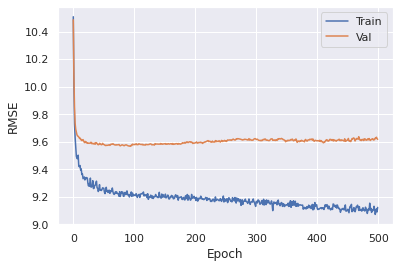

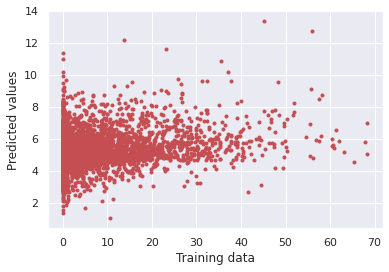

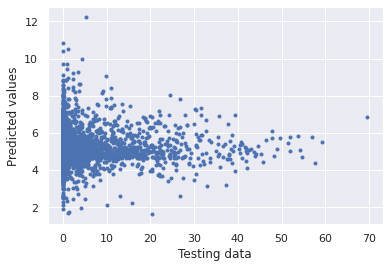

16 0.001 700
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'Year', 'Month', 'Day', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30']
80/80 [==============================] - 0s 2ms/step - loss: 88.33

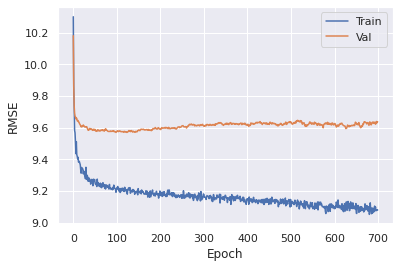

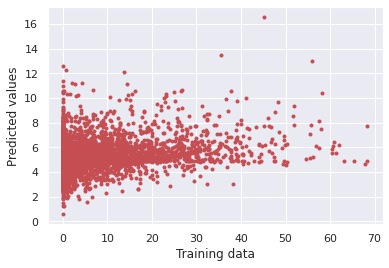

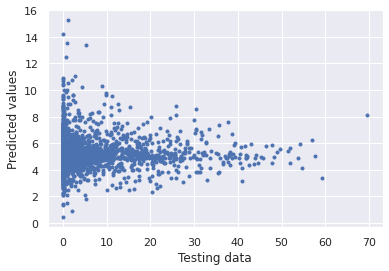

16 <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.InverseTimeDecay object at 0x7f4e7dacaeb8> 500
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'Year', 'Month', 'Day', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_

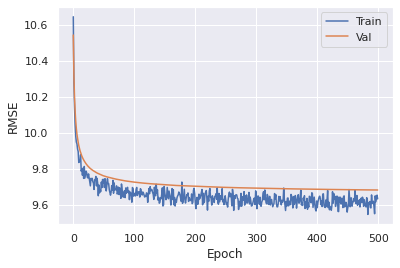

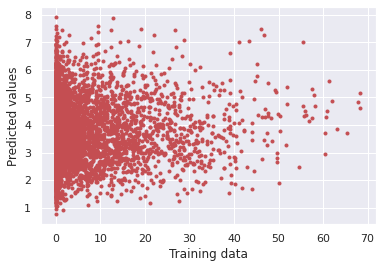

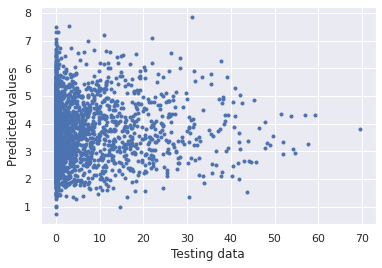

16 <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.InverseTimeDecay object at 0x7f4e7dacaeb8> 700
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'Year', 'Month', 'Day', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_

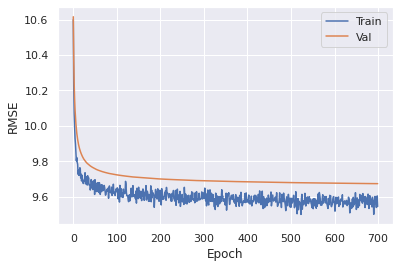

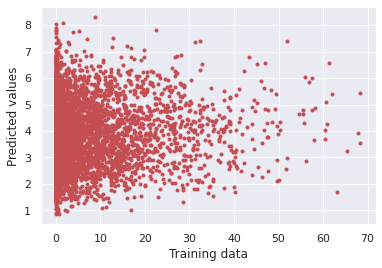

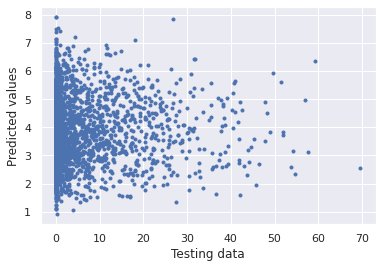

24 0.001 500
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'Year', 'Month', 'Day', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30']
80/80 [==============================] - 0s 2ms/step - loss: 87.59

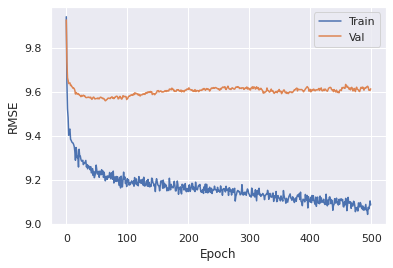

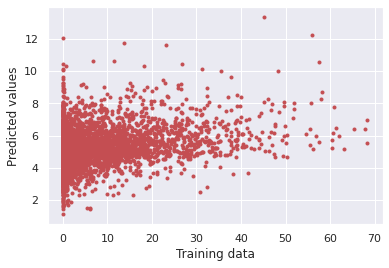

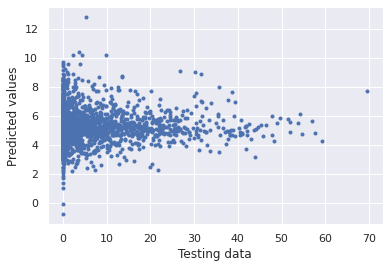

24 0.001 700
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'Year', 'Month', 'Day', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30']
80/80 [==============================] - 0s 2ms/step - loss: 87.66

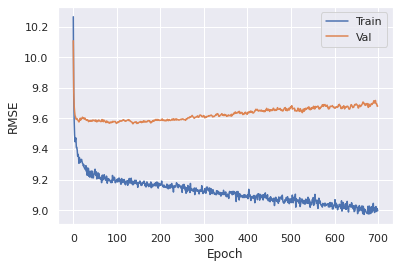

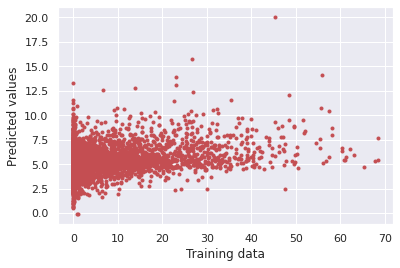

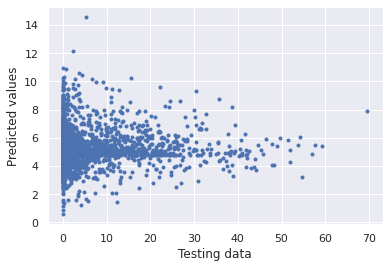

24 <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.InverseTimeDecay object at 0x7f4e7dacaeb8> 500
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'Year', 'Month', 'Day', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_

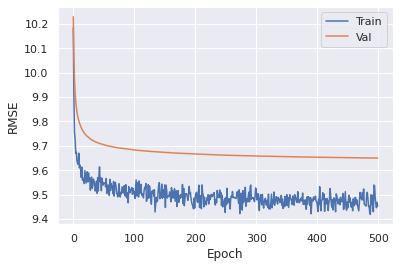

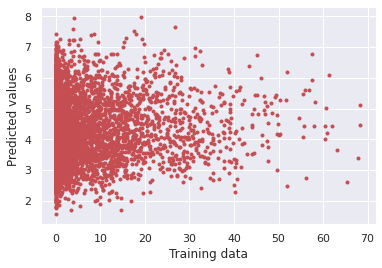

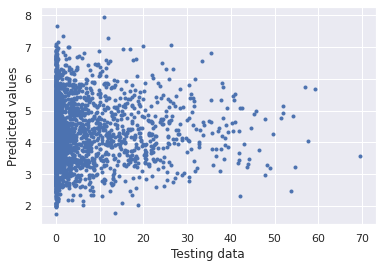

24 <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.InverseTimeDecay object at 0x7f4e7dacaeb8> 700
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'Year', 'Month', 'Day', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_

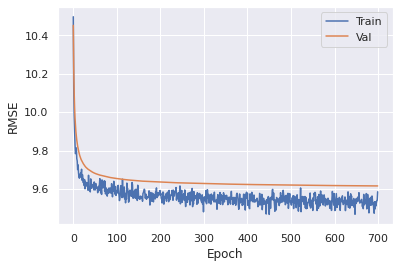

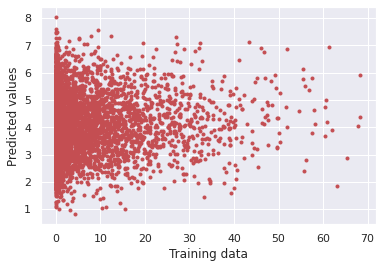

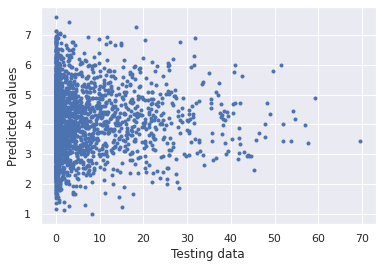

In [11]:
# Create, run, and evaluate regression model
# Try several combinations of hyperparameter values
neurons = [16, 24]
lr      = [0.001, lr_schedule]
epochs  = [500, 700]
for neurons, lr, epochs in product(neurons, lr, epochs):
    print(neurons, lr, epochs)
    predict(df, mtype='reg', target='SESA_Avg_GPCP_Precip', lr=lr, neurons=neurons, epochs=epochs)

16 0.001 500
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30']
[[9.99780606e-01 2.19394471e-04]
 [9.99780606e-01 2.19394471e-04]
 [9.99780606e-01 2.19394

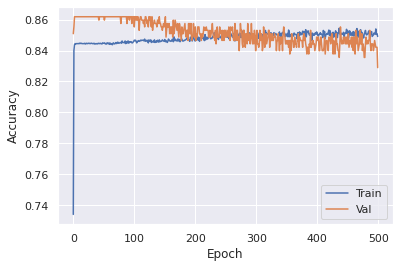

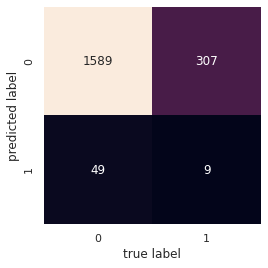

16 0.001 700
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30']
[[9.99780606e-01 2.19394471e-04]
 [9.99780606e-01 2.19394471e-04]
 [9.99780606e-01 2.19394

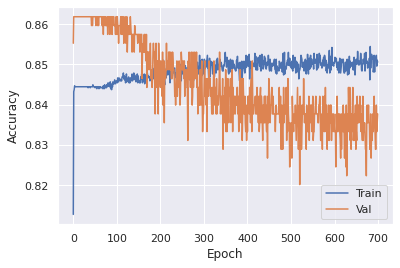

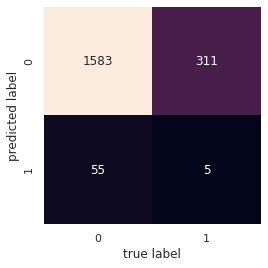

16 <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.InverseTimeDecay object at 0x7f4e10e70240> 500
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_

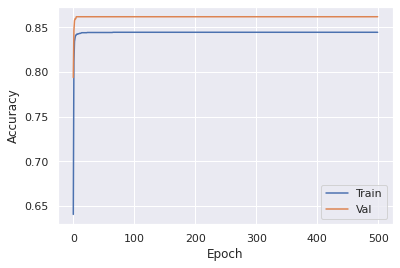

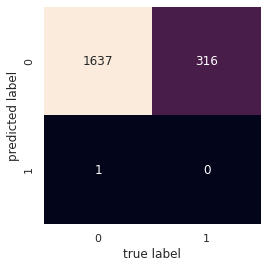

16 <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.InverseTimeDecay object at 0x7f4e10e70240> 700
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_

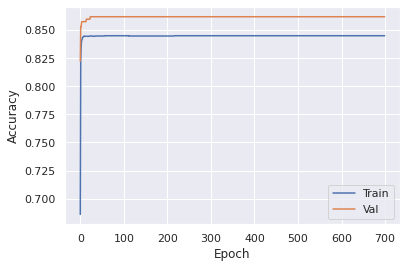

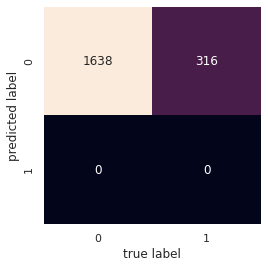

24 0.001 500
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30']
[[9.99780606e-01 2.19394471e-04]
 [9.99780606e-01 2.19394471e-04]
 [9.99780606e-01 2.19394

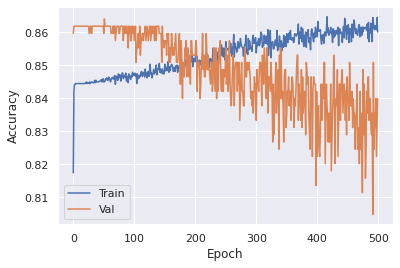

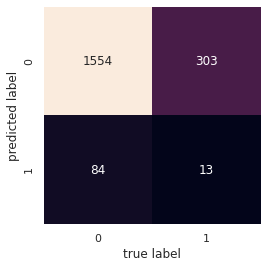

24 0.001 700
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag30']
[[9.99780606e-01 2.19394471e-04]
 [9.99780606e-01 2.19394471e-04]
 [9.99780606e-01 2.19394

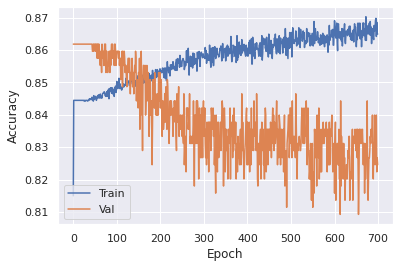

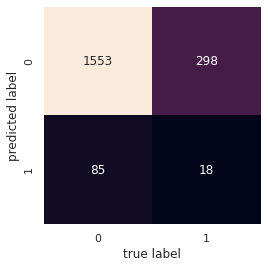

24 <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.InverseTimeDecay object at 0x7f4e10e70240> 500
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_

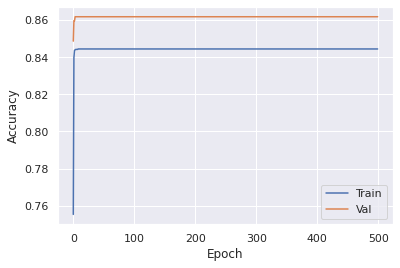

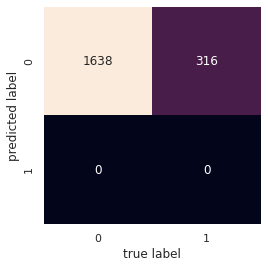

24 <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.InverseTimeDecay object at 0x7f4e10e70240> 700
['MJOPhase_OLR', 'MJOAmplitude_OLR', 'SESA_Avg_ERA5_Soil_Moisture_Lev1', 'SESA_Avg_ERA5_Soil_Moisture_Lev2', 'MJOPhase_OLR_lag5', 'MJOPhase_OLR_lag10', 'MJOPhase_OLR_lag15', 'MJOPhase_OLR_lag20', 'MJOPhase_OLR_lag25', 'MJOPhase_OLR_lag30', 'MJOAmplitude_OLR_lag5', 'MJOAmplitude_OLR_lag10', 'MJOAmplitude_OLR_lag15', 'MJOAmplitude_OLR_lag20', 'MJOAmplitude_OLR_lag25', 'MJOAmplitude_OLR_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev1_lag30', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag5', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag10', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag15', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag20', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_lag25', 'SESA_Avg_ERA5_Soil_Moisture_Lev2_

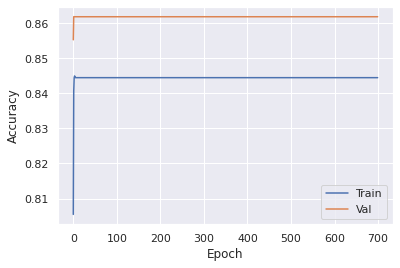

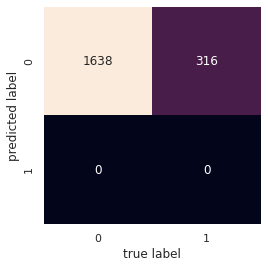

In [46]:
# Create, run, and evaluate regression model
# Try several combinations of hyperparameter values
neurons = [16, 24]
lr      = [0.001, lr_schedule]
epochs  = [500, 700]
for neurons, lr, epochs in product(neurons, lr, epochs):
    print(neurons, lr, epochs)
    predict(df, mtype='class', target='SESA_Avg_GPCP_Precip', lr=lr, neurons=neurons, epochs=epochs)